Import Python packages.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from os.path import exists
from os import remove
from methods.method1.spei_calc_multi import *
from config.data_paths import EXT_STORAGE_DIR

## Load netCDF files
Loading a netCDF file which contains the averaged monthly temperature and another `netCDF` file which contains the precipitation sum for a month as an `xarray.DataArray`.

In [2]:
# Open the netCDF files
day = 1
time_scale = 3
date_target = datetime(2014, 8, day)
date_begin = date_target - relativedelta(months=time_scale-1)
date_end = date_target 
save = False

print(date_begin)
print(date_end)

# Precipitation
prec_file_paths = generate_imerg_filenames(
    date_begin, date_end, f"{EXT_STORAGE_DIR}/drought_data/precipitation/nasa_gpm/Global/monthly/netcdf/avg/")
# Temperature
temp_file_paths = generate_t2m_filenames(
    date_begin - relativedelta(years=1), date_end, f"{EXT_STORAGE_DIR}/drought_data/temperature/era5/Global/monthly/netcdf/avg/")

print(prec_file_paths)
print(temp_file_paths)
len(prec_file_paths) == len(temp_file_paths)

2014-06-01 00:00:00
2014-08-01 00:00:00
['/media/jtrvz/1tb/drought_data/precipitation/nasa_gpm/Global/monthly/netcdf/avg/3B-MO.MS.MRG.3IMERG.20140601-S000000-E235959.06.V07B.HDF5.nc4', '/media/jtrvz/1tb/drought_data/precipitation/nasa_gpm/Global/monthly/netcdf/avg/3B-MO.MS.MRG.3IMERG.20140701-S000000-E235959.07.V07B.HDF5.nc4', '/media/jtrvz/1tb/drought_data/precipitation/nasa_gpm/Global/monthly/netcdf/avg/3B-MO.MS.MRG.3IMERG.20140801-S000000-E235959.08.V07B.HDF5.nc4']
['/media/jtrvz/1tb/drought_data/temperature/era5/Global/monthly/netcdf/avg/t2m_201306.nc', '/media/jtrvz/1tb/drought_data/temperature/era5/Global/monthly/netcdf/avg/t2m_201307.nc', '/media/jtrvz/1tb/drought_data/temperature/era5/Global/monthly/netcdf/avg/t2m_201308.nc', '/media/jtrvz/1tb/drought_data/temperature/era5/Global/monthly/netcdf/avg/t2m_201309.nc', '/media/jtrvz/1tb/drought_data/temperature/era5/Global/monthly/netcdf/avg/t2m_201310.nc', '/media/jtrvz/1tb/drought_data/temperature/era5/Global/monthly/netcdf/avg/t2

False

In [3]:
prec_ds = xr.open_mfdataset(prec_file_paths)
temp_ds = xr.open_mfdataset(temp_file_paths)

# prec_ds['time'] = prec_ds['time'].astype('datetime64[ns]')
# temp_ds['time'] = temp_ds['time'].astype('datetime64[ns]')

In [4]:
prec_ds

<xarray.Dataset> Size: 389MB
Dimensions:                         (time: 3, lon: 3600, lat: 1800, latv: 2,
                                     nv: 2, lonv: 2)
Coordinates:
  * lat                             (lat) float32 7kB -89.95 -89.85 ... 89.95
  * latv                            (latv) int32 8B 0 1
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
  * lonv                            (lonv) int32 8B 0 1
  * nv                              (nv) int32 8B 0 1
  * time                            (time) object 24B 2014-06-01 00:00:00 ......
Data variables:
    precipitationQualityIndex       (time, lon, lat) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    gaugeRelativeWeighting          (time, lon, lat) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    lat_bnds                        (time, lat, latv) float32 43kB dask.array<chunksize=(1, 1024, 2), meta=np.ndarray>
    precipitation                   (time, lon, lat) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    time_bnds                       (time, nv) object 48B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds                        (time, lon, lonv) float32 86kB dask.array<chunksize=(1, 1024, 2), meta=np.ndarray>
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-MONTH/07;\nDOIa...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2024-02-20 12:18:12 GMT Hyrax-1.16.3 htt...

In [5]:
temp_ds

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 15, longitude: 3600, latitude: 1801, expver: 2)
Coordinates:
  * time       (time) datetime64[ns] 120B 2013-06-01 2013-07-01 ... 2014-08-01
  * longitude  (longitude) float32 14kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
  * latitude   (latitude) float32 7kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * expver     (expver) int32 8B 1 5
Data variables:
    t2m        (time, expver, latitude, longitude) float64 2GB dask.array<chunksize=(1, 2, 1801, 3600), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Feb 21 17:15:59 2024: cdo splityearmon data.nc t2m_\n20...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

## Data preprocessing

### Preprocessing: Precipitation dataset

In [6]:
# Rearrange the dimensions of the precipitation xarray.DataArray
prec_ds = preprocess_prec(prec_ds)
prec_ds

<xarray.Dataset> Size: 389MB
Dimensions:                         (time: 3, lat: 1800, lon: 3600, latv: 2,
                                     nv: 2, lonv: 2)
Coordinates:
  * lat                             (lat) float32 7kB -89.95 -89.85 ... 89.95
  * latv                            (latv) int32 8B 0 1
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
  * lonv                            (lonv) int32 8B 0 1
  * nv                              (nv) int32 8B 0 1
  * time                            (time) datetime64[ns] 24B 2014-06-01 ... ...
Data variables:
    precipitationQualityIndex       (time, lat, lon) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    gaugeRelativeWeighting          (time, lat, lon) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    lat_bnds                        (time, lat, latv) float32 43kB dask.array<chunksize=(1, 1024, 2), meta=np.ndarray>
    precipitation                   (time, lat, lon) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lat, lon) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    randomError                     (time, lat, lon) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    time_bnds                       (time, nv) object 48B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds                        (time, lon, lonv) float32 86kB dask.array<chunksize=(1, 1024, 2), meta=np.ndarray>
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-MONTH/07;\nDOIa...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2024-02-20 12:18:12 GMT Hyrax-1.16.3 htt...

In [7]:
# Current datetime used for file name's suffix
dt = datetime.now()
dt_str = dt.strftime("%Y%m%d_%H%M%S")

### Preprocessing: Temperature dataset
The longitude of the **temperature netCDF file** has the range `0.00-180.00` which is why we convert the longitude to the range `-180.00-180.00`.

In [8]:
temp_ds = preprocess_temp(temp_ds)

/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [9]:
# Show temperature DataArray
temp_ds

<xarray.Dataset> Size: 778MB
Dimensions:  (time: 15, lat: 1801, lon: 3600)
Coordinates:
  * time     (time) datetime64[ns] 120B 2013-06-01 2013-07-01 ... 2014-08-01
  * lat      (lat) float32 7kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
    expver   int32 4B 1
  * lon      (lon) float32 14kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Data variables:
    t2m      (time, lat, lon) float64 778MB dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Feb 21 17:15:59 2024: cdo splityearmon data.nc t2m_\n20...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

## Select Germany as study area
For this study we use the latitude and longtitude bounds of the European country Germany.

**Lat:** 47.0, 55.0\
**Lon:** 5.5, 15.0

In [10]:
# Spatial subset for Germany (Europe)
lat_bounds = [47.0, 55.0]
lon_bounds = [5.5, 15.0]

In [11]:
# Select the data for Germany
prec_germany = spatial_subset(ds=prec_ds, lat_bounds=lat_bounds, lon_bounds=lon_bounds)
temp_germany = spatial_subset(ds=temp_ds, lat_bounds=lat_bounds, lon_bounds=lon_bounds)


In [12]:
prec_germany

<xarray.Dataset> Size: 461kB
Dimensions:                         (time: 3, lat: 80, lon: 95, latv: 2, nv: 2,
                                     lonv: 2)
Coordinates:
  * lat                             (lat) float32 320B 47.05 47.15 ... 54.95
  * latv                            (latv) int32 8B 0 1
  * lon                             (lon) float32 380B 5.55 5.65 ... 14.85 14.95
  * lonv                            (lonv) int32 8B 0 1
  * nv                              (nv) int32 8B 0 1
  * time                            (time) datetime64[ns] 24B 2014-06-01 ... ...
Data variables:
    precipitationQualityIndex       (time, lat, lon) float32 91kB dask.array<chunksize=(1, 80, 95), meta=np.ndarray>
    gaugeRelativeWeighting          (time, lat, lon) float32 91kB dask.array<chunksize=(1, 80, 95), meta=np.ndarray>
    lat_bnds                        (time, lat, latv) float32 2kB dask.array<chunksize=(1, 80, 2), meta=np.ndarray>
    precipitation                   (time, lat, lon) float32 91kB dask.array<chunksize=(1, 80, 95), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lat, lon) float32 91kB dask.array<chunksize=(1, 80, 95), meta=np.ndarray>
    randomError                     (time, lat, lon) float32 91kB dask.array<chunksize=(1, 80, 95), meta=np.ndarray>
    time_bnds                       (time, nv) object 48B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds                        (time, lon, lonv) float32 2kB dask.array<chunksize=(1, 95, 2), meta=np.ndarray>
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-MONTH/07;\nDOIa...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2024-02-20 12:18:12 GMT Hyrax-1.16.3 htt...

In [13]:
temp_germany

<xarray.Dataset> Size: 934kB
Dimensions:  (time: 15, lat: 81, lon: 96)
Coordinates:
  * time     (time) datetime64[ns] 120B 2013-06-01 2013-07-01 ... 2014-08-01
  * lat      (lat) float32 324B 47.0 47.1 47.2 47.3 47.4 ... 54.7 54.8 54.9 55.0
    expver   int32 4B 1
  * lon      (lon) float32 384B 5.5 5.6 5.7 5.8 5.9 ... 14.6 14.7 14.8 14.9 15.0
Data variables:
    t2m      (time, lat, lon) float64 933kB dask.array<chunksize=(1, 81, 96), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Feb 21 17:15:59 2024: cdo splityearmon data.nc t2m_\n20...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

## Calculate PET

In [14]:
pet_germany, temp_germany = calc_pet_thornthwaite(temp_germany, temp_germany.sel(time=slice(date_begin-relativedelta(years=1), date_begin)))
if save:
    save_as_nc(pet_germany, f"output/pet_germany_multi_{dt_str}.nc")

In [15]:
pet_germany

<xarray.DataArray 'pet' (time: 15, lat: 81, lon: 96)> Size: 933kB
dask.array<mul, shape=(15, 81, 96), dtype=float64, chunksize=(1, 81, 96), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 120B 2013-06-01 2013-07-01 ... 2014-08-01
  * lat      (lat) float32 324B 47.0 47.1 47.2 47.3 47.4 ... 54.7 54.8 54.9 55.0
    expver   int32 4B 1
  * lon      (lon) float32 384B 5.5 5.6 5.7 5.8 5.9 ... 14.6 14.7 14.8 14.9 15.0

In [16]:
pet_germany = preprocess_pet(pet_germany, prec_germany)

In [17]:
difference = calc_difference(prec_germany, pet_germany)
if save:
    save_as_nc(difference, f"output/diff_germany_multi_{dt_str}.nc")
difference

<xarray.DataArray (time: 3, lat: 80, lon: 95)> Size: 182kB
dask.array<sub, shape=(3, 80, 95), dtype=float64, chunksize=(1, 80, 95), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 320B 47.05 47.15 47.25 47.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 380B 5.55 5.65 5.75 5.85 ... 14.65 14.75 14.85 14.95
  * time     (time) datetime64[ns] 24B 2014-06-01 2014-07-01 2014-08-01
    expver   int32 4B 1

In [18]:
cdf_vals = calc_cdf_values(difference)
cdf_vals

<xarray.DataArray (time: 3, lat: 80, lon: 95)> Size: 182kB
array([[[0.82603479, 0.80862145, 0.75160791, ..., 0.20217034,
         0.2136857 , 0.23270433],
        [0.81342205, 0.79772869, 0.7659987 , ..., 0.19172264,
         0.202759  , 0.21942444],
        [0.80117137, 0.78985878, 0.77551282, ..., 0.1762434 ,
         0.18758143, 0.20116074],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.91989842, 0.91451396, 0.87384868, ..., 0.08805456,
         0.09077092, 0.09504677],
        [0.9046028 , 0.89881623, 0.87447891, ..., 0.08579769,
         0.08754194, 0.0904132 ],
        [0.88495828, 0.88148163, 0.86680726, ..., 0.08225823,
         0.08424279, 0.08634626],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.98698881, 0.98592907, 0.97971508, ..., 0.18245464,
         0.19214802, 0.20831875],
        [0.98617942, 0.98516365, 0.98149274, ..., 0.20059219,
         0.2047715 , 0.21104734],
        [0.98514749, 0.98445041, 0.98203447, ..., 0.19961066,
         0.20582167, 0.20877431],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * lat      (lat) float32 320B 47.05 47.15 47.25 47.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 380B 5.55 5.65 5.75 5.85 ... 14.65 14.75 14.85 14.95
  * time     (time) datetime64[ns] 24B 2014-06-01 2014-07-01 2014-08-01
    expver   int32 4B 1

In [19]:
spei = calc_spei(difference)
spei

<xarray.DataArray 'spei' (time: 3, lat: 80, lon: 95)> Size: 182kB
array([[[ 0.9009511 ,  0.86263685,  0.74421232, ..., -0.82128527,
         -0.76224377, -0.67002025],
        [ 0.87306206,  0.83931424,  0.77340545, ..., -0.87716629,
         -0.81820409, -0.73375052],
        [ 0.84663879,  0.8227161 ,  0.79290941, ..., -0.9644365 ,
         -0.8999687 , -0.82658606],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 1.15440031,  1.1358965 ,  1.01618924, ..., -1.61686498,
         -1.59073154, -1.55073614],
        [ 1.10382544,  1.08611462,  1.01784791, ..., -1.63903299,
         -1.62186305, -1.5941399 ],
        [ 1.04616416,  1.03660858,  0.99796377, ..., -1.6746813 ,
         -1.65455717, -1.63360549],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 1.58331837,  1.56699989,  1.48895503, ..., -0.92873982,
         -0.87484566, -0.78944251],
        [ 1.57075249,  1.55588723,  1.50882406, ..., -0.82958027,
         -0.80772267, -0.77554652],
        [ 1.55565817,  1.54598545,  1.51521505, ..., -0.83476503,
         -0.80228516, -0.78711253],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * lat      (lat) float32 320B 47.05 47.15 47.25 47.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 380B 5.55 5.65 5.75 5.85 ... 14.65 14.75 14.85 14.95
  * time     (time) datetime64[ns] 24B 2014-06-01 2014-07-01 2014-08-01
    expver   int32 4B 1

This is the SPEI diagram which shows the SPEI values.
The indices should be interpreted as such:

| Range of Values   | Regime            |
|-------------------|-------------------|
| 2 < SPEI <= MAX     | Extremely Wet     |
| 1.5 < SPEI <= 2.0   | Very Wet          |
| 1.0 < SPEI <=1.5    | Moderately Wet    |
| -1.0 < SPEI <= 1.0  | Normal Conditions |
| -1.5 < SPEI <= -1.0 | Moderately Dry    |
| -2.0 < SPEI <= -1.5 | Very Dry          |
| MIN <= SPEI <= -2.0 | Extremely Dry     |

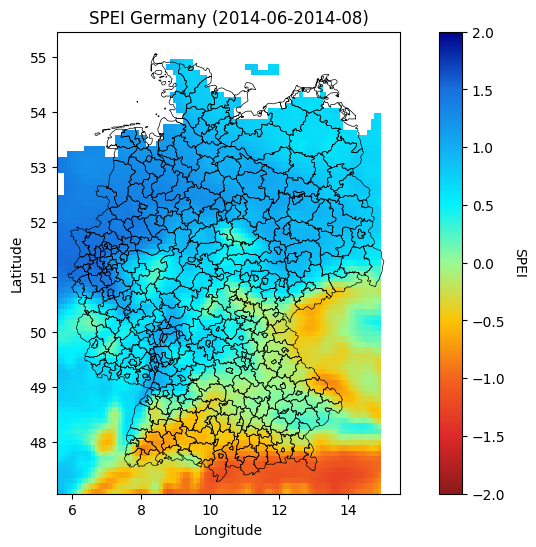

In [21]:
shape_file_path = f'{EXT_STORAGE_DIR}/shape_ger/vg2500_krs.shp'
spei_plot(spei, shape_file_path, lon_bounds, lat_bounds,
          f"SPEI Germany ({date_begin.strftime('%Y-%m')}-{date_end.strftime('%Y-%m')})", "output/test-multi.png")

In [ ]:
if save:
    save_as_nc(spei, f"output/spei_multi_{date_begin.strftime('%Y%m')}-{date_end.strftime('%Y%m')}_{dt_str}.nc")

The plot shows the map of Germany with the `time_scale`-month SPEI values for the `date_target`'s month.

The "Thornthwaite" method is used to calculate the potential evapotranspiration (PET) with the temperature data.